<a href="https://colab.research.google.com/github/IgnacioRiffop/-Clasificaci-n-de-d-gitos-manuscritos-con-Deep-Learning-MNIST-/blob/main/EA2_WeatherAUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CRISP-DM: Análisis de Datos Climáticos en Australia

Esta notebook implementa las tres primeras fases de la metodología CRISP-DM:
1. Business Understanding
2. Data Understanding
3. Data Preparation

Las transformaciones aplicadas previenen overfitting/underfitting y preparan los datos para modelos supervisados y no supervisados.

## Fase 1: Business Understanding

**Objetivo de Negocio**:
- Comprender y modelar la probabilidad de lluvia al día siguiente (`RainTomorrow`) en Australia.
- Generar insights para optimizar la planificación agrícola y la gestión de recursos hídricos.

**Stakeholders**:
- Meteorólogos y especialistas en clima
- Agricultores y comunidades rurales
- Autoridades de gestión de recursos hídricos

**Preguntas Clave**:
1. ¿Cuáles son las variables meteorológicas más influyentes en la lluvia al día siguiente?
2. ¿Existen patrones espaciales (por ubicación) y/o temporales (por mes/estación)?
3. ¿Cómo agrupar días según perfiles climáticos para identificar periodos de alto riesgo?

## Fase 2: Data Understanding

En esta fase realizamos la inspección inicial del conjunto de datos, identificamos la estructura, valores faltantes, tipos de variables y comenzamos a buscar patrones o relaciones entre variables.

In [ ]:
# Importar librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Fase 2: Data Understanding

Cargamos el dataset y realizamos una inspección preliminar.


In [ ]:
# Cargar datos
from google.colab import files
uploaded = files.upload()

# Cargar el archivo luego de subirlo
import pandas as pd
df = pd.read_csv("weatherAUS.csv")
print(f"Dimensiones originales: {df.shape}")

Saving weatherAUS.csv to weatherAUS (2).csv
Dimensiones originales: (142193, 24)


### Revisión de estructura del dataset
- Columnas, tipos de datos y valores faltantes.

In [ ]:
# Información de columnas y valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [ ]:
# Contar cuántos valores nulos hay por columna
df.isnull().sum()

,0
Date,0
Location,0
MinTemp,637
MaxTemp,322
Rainfall,1406
Evaporation,60843
Sunshine,67816
WindGustDir,9330
WindGustSpeed,9270
WindDir9am,10013


### Estadísticas descriptivas de variables numéricas

## Análisis de Valores Nulos

A continuación se detallan las columnas con valores faltantes en el dataset y su posible impacto:

| Variable          | Nulos    | % Aprox. | Observaciones |
|------------------|----------|----------|----------------|
| Evaporation       | 60,843   | ~43%     | Alta proporción de nulos, considerar eliminar la variable o imputar cuidadosamente. |
| Sunshine          | 67,816   | ~48%     | Muy incompleta. Puede ser eliminada o imputada si es crítica. |
| Cloud9am          | 53,657   | ~38%     | Nube en la mañana, escala discreta. Evaluar si imputar con moda. |
| Cloud3pm          | 57,094   | ~40%     | Similar a `Cloud9am`. También discreta. |
| Pressure9am       | 14,014   | ~10%     | Variable importante para el clima, considerar imputación por regresión u otras técnicas. |
| Pressure3pm       | 13,981   | ~10%     | Idem anterior. |
| WindGustDir       | 9,330    | ~6.6%    | Dirección categórica, imputable con moda o según contexto. |
| WindGustSpeed     | 9,270    | ~6.5%    | Velocidad de ráfagas. Importante en predicción meteorológica. |
| WindDir9am        | 10,013   | ~7%      | Categórica, dirección del viento. Imputable con moda. |
| WindDir3pm        | 3,778    | ~2.6%    | Menos afectada. |
| WindSpeed9am      | 1,348    | ~0.9%    | Pocos nulos, puede imputarse fácilmente. |
| WindSpeed3pm      | 2,630    | ~1.8%    | Similar. |
| Humidity9am       | 1,774    | ~1.2%    | Imputable. Variable importante. |
| Humidity3pm       | 3,610    | ~2.5%    | Ídem. |
| Temp9am           | 904      | ~0.6%    | Pocos nulos, se puede imputar con facilidad. |
| Temp3pm           | 2,726    | ~1.9%    | Imputable. |
| MinTemp           | 637      | ~0.4%    | Muy pocos nulos, fácilmente imputable. |
| MaxTemp           | 322      | ~0.2%    | Ídem. |
| Rainfall          | 1,406    | ~1%      | Importante. Imputable o dejar como está si se analiza en relación con `RainToday`. |
| RainToday         | 1,406    | ~1%      | Mismo número que `Rainfall`, probablemente relacionados. |
| RainTomorrow      | 0        | 0%       | Variable objetivo. Sin nulos. ✅ |
| RISK_MM           | 0        | 0%       | Variable de predicción. Sin nulos. ✅ |




In [ ]:
# Estadísticas descriptivas de variables numéricas
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


## Análisis Estadístico Descriptivo del Dataset Climático

### 1. Datos Faltantes
- Varias columnas tienen una cantidad considerable de valores faltantes:
  - `Evaporation`: ~43% faltante.
  - `Sunshine`: ~48% faltante.
  - `Cloud9am` y `Cloud3pm`: ~38%-40% faltante.
  - `Pressure9am` y `Pressure3pm`: ~10% faltante.
- Otras variables como `WindGustSpeed`, `Humidity3pm`, etc., tienen valores más completos pero no perfectos.
- **Recomendación**: evaluar estrategias de imputación o exclusión según el análisis posterior.

---

### 2. Lluvia (`Rainfall` y `RISK_MM`)
- `Rainfall` tiene media 2.35 mm, pero la mediana es 0 mm → **sesgo positivo** (mayoría de días sin lluvia).
- `RISK_MM` también tiene mediana 0 y máximo de 371 mm.
- **Recomendación**: si el objetivo es predecir si lloverá, se puede transformar `RISK_MM` a variable binaria (e.g. `RISK_MM > 1` → "lloverá").

---

### 3. Temperaturas (`MinTemp`, `MaxTemp`, `Temp9am`, `Temp3pm`)
- Valores coherentes y consistentes entre sí.
- Rangos normales, aunque extremos como -8.5 °C y 48.1 °C pueden requerir revisión.
- **Recomendación**: tener cuidado al normalizar por presencia de valores negativos.

---

### 4. Viento (`WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm`)
- `WindGustSpeed` promedio ~40 km/h, con máximos de hasta 135 km/h.
- `WindSpeed9am` llega hasta 130 km/h, lo cual podría ser un valor atípico.
- **Recomendación**: revisar valores extremos y considerar su tratamiento.

---

### 5. Humedad y Presión
- `Humidity9am` promedio 69%, `Humidity3pm` 51%.
- Algunos valores de 0% podrían ser errores de medición.
- `Pressure9am/3pm` tienen valores mínimos (977 hPa) posiblemente relacionados a tormentas o errores.
- **Recomendación**: análisis de valores extremos y distribución.

---

### 6. Evaporación y Horas de Sol (`Evaporation`, `Sunshine`)
- `Evaporation` tiene un máximo de 145 mm, posiblemente atípico.
- `Sunshine` tiene un promedio de 7.6 horas y máximo de 14.5 horas, lo cual es razonable.
- **Recomendación**: validar valores extremos de evaporación.

---

### 7. Nubosidad (`Cloud9am`, `Cloud3pm`)
- Escala aparentemente discreta de 0 a 9.
- Promedios similares en la mañana y tarde (~4.5).
- **Recomendación**: revisar codificación y utilidad en modelos.



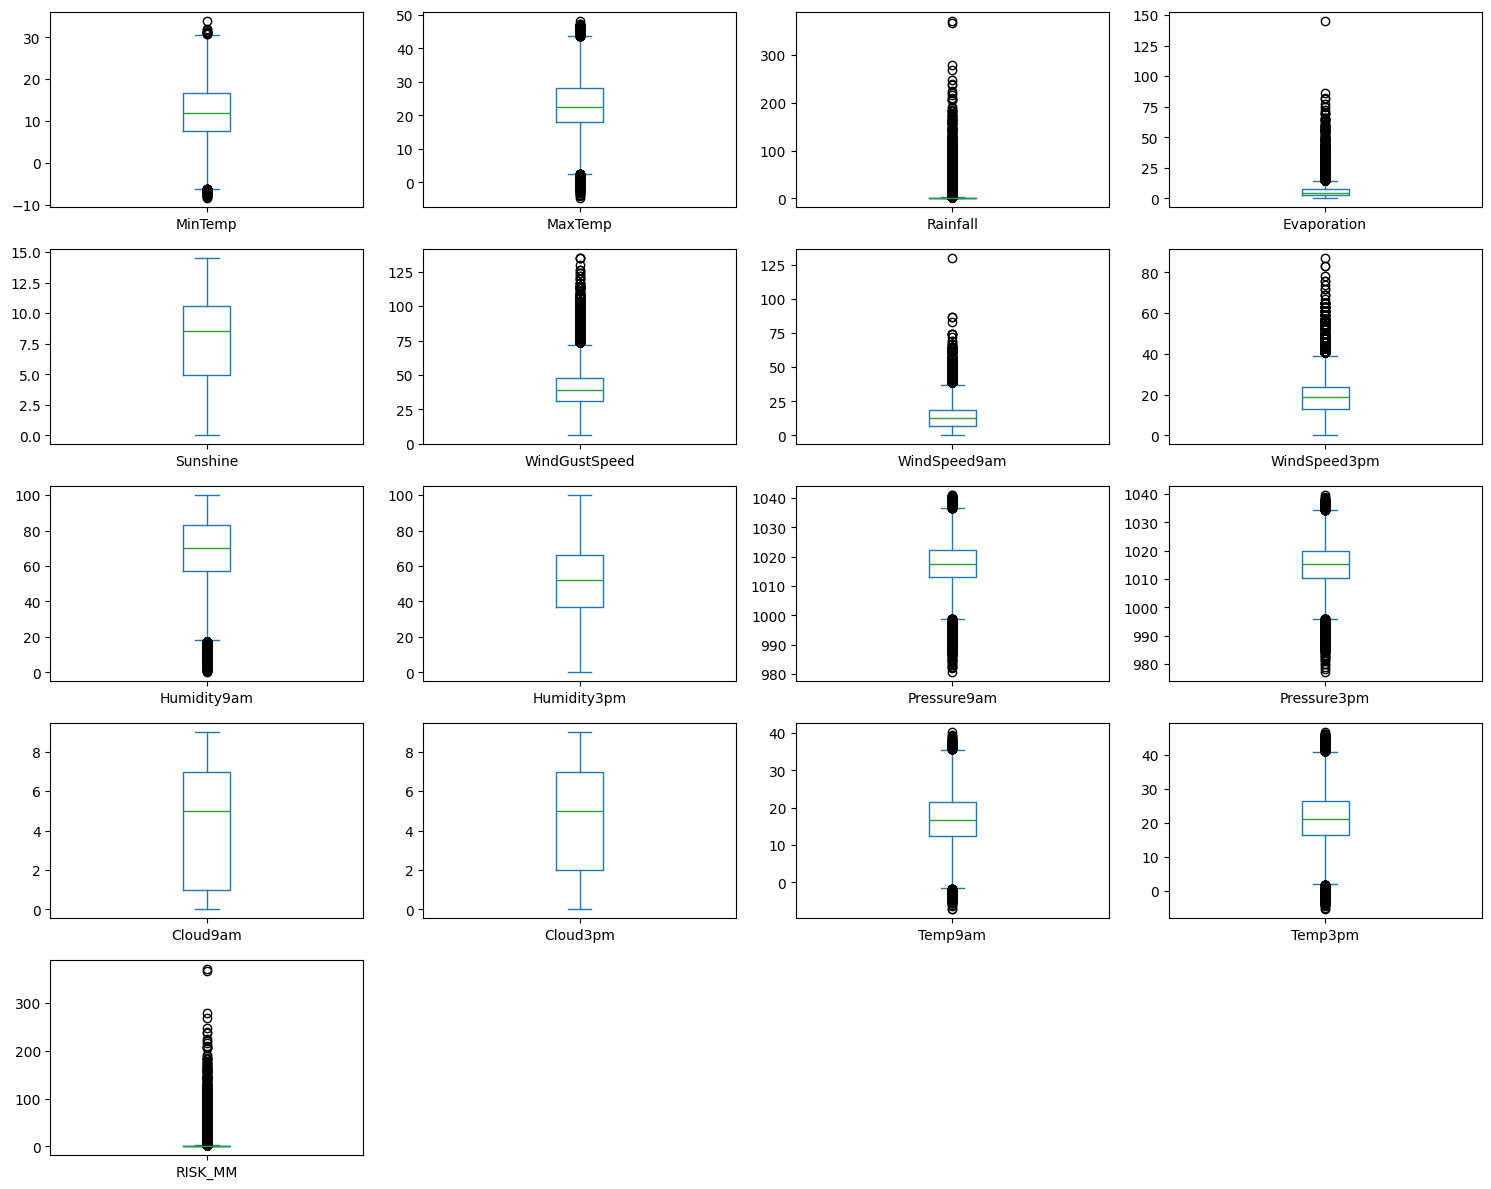

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df.select_dtypes(include='number').plot(kind='box', subplots=True, layout=(5, 4), figsize=(15, 12), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

### Análisis Exploratorio
- Histogramas y boxplots para distribución y outliers.
- Matriz de correlación para relaciones lineales.

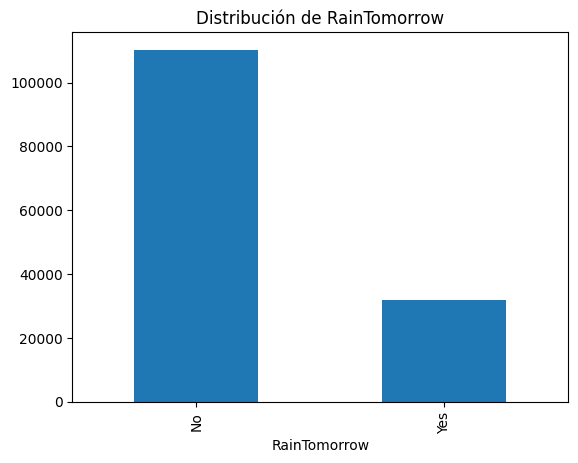

In [ ]:
# %%
# Distribución de la variable objetivo
df['RainTomorrow'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribución de RainTomorrow')
plt.show()


### Matriz de correlación entre variables numéricas

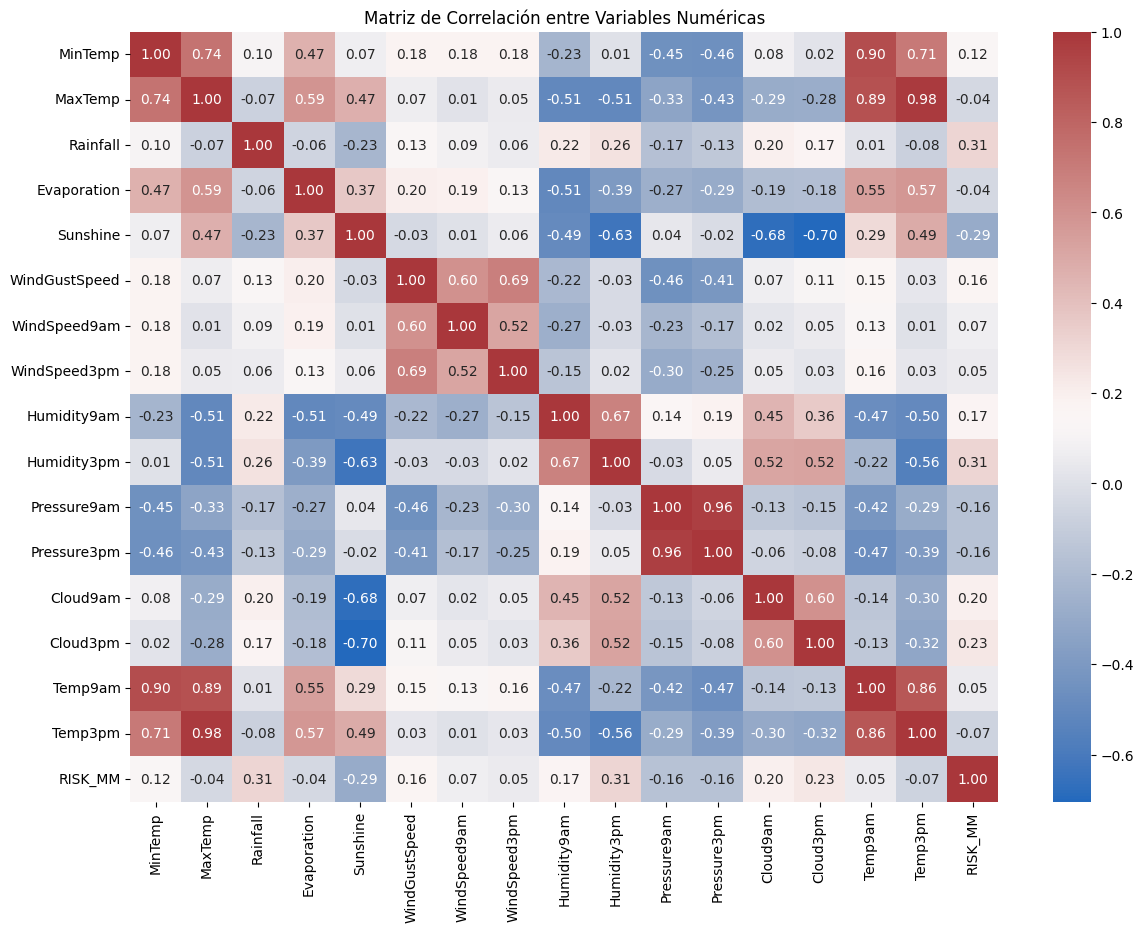

In [ ]:
# %%
# Matriz de correlación
df_num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(14,10))
sns.heatmap(df_num.corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()


In [ ]:
# Selecciona solo columnas numéricas
num_df = df.select_dtypes(include=['int64', 'float64'])

# Añade la variable objetivo codificada para correlacionar
num_df['RainTomorrow'] = LabelEncoder().fit_transform(df['RainTomorrow'])

# Ahora calcula la correlación con la variable objetivo
print(num_df.corr()['RainTomorrow'].sort_values(ascending=False))


RainTomorrow      1.000000
RISK_MM           0.501485
Humidity3pm       0.439678
Humidity9am       0.255158
Cloud3pm          0.239996
Rainfall          0.235087
WindGustSpeed     0.222729
Cloud9am          0.209961
WindSpeed9am      0.090524
WindSpeed3pm      0.086909
MinTemp           0.083717
WindGustDirDeg    0.049418
Temp9am          -0.025582
MaxTemp          -0.159087
Temp3pm          -0.190286
Pressure3pm      -0.218989
Pressure9am      -0.240331
DeltaTemp        -0.335256
Name: RainTomorrow, dtype: float64


## Fase 3: Data Preparation

En esta fase transformamos los datos para que puedan ser usados por algoritmos de machine learning. Esto incluye:
- Limpieza de valores nulos.
- Imputación.
- Creación de nuevas variables (feature engineering).
- Escalado y codificación.



In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer

# Suponiendo que ya cargaste tu DataFrame como df

# -------------------------
# 1. Eliminar columnas con demasiados nulos
# -------------------------
df.drop(['Evaporation', 'Sunshine'], axis=1, inplace=True)

# -------------------------
# 2. Imputar columnas categóricas con moda
# -------------------------
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
for col in categorical_cols:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)

# -------------------------
# 3. Imputar Cloud9am y Cloud3pm con moda
# -------------------------
for col in ['Cloud9am', 'Cloud3pm']:
    if col in df.columns:
        mode = df[col].mode()[0]
        df[col] = df[col].fillna(mode)

# -------------------------
# 4. Imputar Rainfall con 0 (asumiendo que el nulo significa 'no llovió')
# -------------------------
df['Rainfall'] = df['Rainfall'].fillna(0)

# -------------------------
# 5. Imputar variables numéricas con pocos nulos usando la media
# -------------------------
mean_impute_cols = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm',
                    'Humidity9am', 'Humidity3pm', 'WindSpeed9am', 'WindSpeed3pm']
for col in mean_impute_cols:
    df[col] = df[col].fillna(df[col].mean())

# -------------------------
# 6. Imputar Pressure9am y Pressure3pm con KNN Imputer
# -------------------------
knn_cols = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm',
            'Humidity9am', 'Humidity3pm', 'WindSpeed9am', 'WindSpeed3pm']

knn_data = df[knn_cols]
knn_imputer = KNNImputer(n_neighbors=5)
knn_result = knn_imputer.fit_transform(knn_data)

df[knn_cols] = pd.DataFrame(knn_result, columns=knn_cols, index=df.index)

# -------------------------
# 7. Imputar WindGustSpeed con KNN
# -------------------------
features_for_knn_wind = ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                         'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm']

wind_data = df[features_for_knn_wind]
wind_imputer = KNNImputer(n_neighbors=5)
wind_result = wind_imputer.fit_transform(wind_data)

df['WindGustSpeed'] = wind_result[:, 0]

# -------------------------
# 8. Verificación final
# -------------------------
print("Valores nulos restantes por columna:")
print(df.isnull().sum().sort_values(ascending=False))



Valores nulos restantes por columna:
Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64


## Limpieza e imputación de valores nulos

El siguiente script realiza la limpieza del conjunto de datos, específicamente el tratamiento de valores nulos en distintas variables, de acuerdo con su naturaleza:

### 1. Eliminación de columnas con demasiados valores nulos

Se eliminan las columnas:
- `Evaporation`
- `Sunshine`

Estas variables tienen más del 50% de valores faltantes, lo que podría sesgar los resultados si se imputaran de forma arbitraria.

---

### 2. Imputación de columnas categóricas con la moda

Las siguientes variables categóricas se imputan con su valor más frecuente (moda):
- `WindGustDir`
- `WindDir9am`
- `WindDir3pm`
- `RainToday`

Este método es adecuado ya que en variables categóricas no ordinales, el valor más frecuente suele ser una aproximación razonable.

---

### 3. Imputación de cobertura nubosa con la moda

Se imputan con la moda las variables:
- `Cloud9am`
- `Cloud3pm`

Aunque son variables numéricas, suelen tener un rango discreto (por ejemplo: 0 a 8). La moda permite conservar su distribución original.

---

### 4. Imputación de `Rainfall` con 0

Se asume que un valor nulo en `Rainfall` indica que **no llovió**, por lo que se imputan con `0`. Esta decisión se basa en la lógica del dominio.

---

### 5. Imputación de variables numéricas con pocos nulos mediante la media

Se imputan con la media las siguientes variables continuas:
- `MinTemp`, `MaxTemp`
- `Temp9am`, `Temp3pm`
- `Humidity9am`, `Humidity3pm`
- `WindSpeed9am`, `WindSpeed3pm`

La imputación con la media es adecuada en este caso porque la cantidad de valores faltantes es baja y estas variables tienen una distribución razonablemente normal.

---

### 6. Imputación de `Pressure9am` y `Pressure3pm` con KNN Imputer

Para estas variables con mayor cantidad de nulos, se utiliza **KNN Imputer** con `n_neighbors=5`, usando como variables de referencia:
- `Temp9am`, `Temp3pm`
- `Humidity9am`, `Humidity3pm`
- `WindSpeed9am`, `WindSpeed3pm`

Este método permite imputar en base a muestras similares del dataset, capturando relaciones entre variables.

---

### 7. Imputación de `WindGustSpeed` con KNN Imputer

Se imputan los valores faltantes de `WindGustSpeed` con KNN, usando como variables predictoras:
- `WindSpeed9am`, `WindSpeed3pm`
- `Humidity9am`, `Humidity3pm`
- `Temp9am`, `Temp3pm`

Esto permite estimar los valores de ráfagas de viento usando el comportamiento del clima y el viento en el mismo día.

---

### 8. Verificación final

Se imprime un resumen con los valores nulos restantes por columna para confirmar que el conjunto de datos está completamente limpio.


## Feature Engineering

En esta sección se crean nuevas variables que pueden aportar información valiosa para los modelos predictivos:

- **Fecha a formato datetime:** Convertimos la columna `Date` a tipo datetime para facilitar la extracción de componentes temporales.

- **Mes (`Month`):** Se extrae el mes del año a partir de la fecha.

- **Estación del año (`Season`):** Se calcula en base al mes, dividiendo el año en 4 estaciones:
  - 1: Primavera
  - 2: Verano
  - 3: Otoño
  - 4: Invierno

- **Amplitud térmica (`DeltaTemp`):** Diferencia entre la temperatura máxima y mínima diaria (`MaxTemp - MinTemp`), que puede reflejar la variabilidad térmica de cada día.

- **Conversión de direcciones de viento a grados:** Se transforma la dirección del viento de formato categórico (`N`, `NE`, `E`, etc.) a grados para facilitar análisis numéricos y modelado.

---


In [ ]:

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Season'] = (df['Month'] % 12 + 3) // 3
df['DeltaTemp'] = df['MaxTemp'] - df['MinTemp']

def wind_to_deg(dir_series):
    mapping = {'N':0,'NE':45,'E':90,'SE':135,'S':180,'SW':225,'W':270,'NW':315}
    return dir_series.map(mapping)

df['WindGustDirDeg'] = wind_to_deg(df['WindGustDir'])


### División de datos para modelado supervisado
Separamos variables predictoras (`X`) y la variable objetivo (`y`). Luego dividimos los datos en entrenamiento y prueba.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Date','RainTomorrow'])
y = LabelEncoder().fit_transform(df['RainTomorrow'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (113754, 24), Test: (28439, 24)


### Preparación para modelado
Aplicamos codificación one-hot para las variables categóricas y escalado para las variables numéricas.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_feats = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_feats = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

continuas = numeric_feats
categoricas = cat_feats

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipeline, continuas),
    ('cat', cat_pipeline, categoricas)
])


## Fase 4: Modeling

En esta fase se seleccionan y entrenan modelos supervisados utilizando los datos ya preparados. Se comparan sus resultados utilizando métricas de evaluación. Para este análisis se han considerado dos modelos populares de clasificación:

- **Regresión Logística**: modelo lineal base para clasificación binaria.
- **Random Forest**: modelo de ensamble de árboles de decisión, más robusto a relaciones no lineales y outliers.

### Modelado Supervisado: Comparación de Modelos
A continuación entrenaremos y compararemos dos modelos supervisados populares: Regresión Logística y Random Forest. Evaluaremos usando F1-score y AUC.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score



In [ ]:
numeric_feats = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_feats = X_train.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# Pipeline con Regresión Logística
# Aplicamos el pipeline al conjunto de entrenamiento imputado
X_train_clean = preprocess.fit_transform(X_train)
X_test_clean = preprocess.transform(X_test)


In [ ]:
# Entrenamos Regresión Logística directamente
pipe_lr = LogisticRegression(max_iter=1000)
pipe_lr.fit(X_train_clean, y_train)
y_pred_lr = pipe_lr.predict(X_test_clean)
y_prob_lr = pipe_lr.predict_proba(X_test_clean)[:,1]

In [ ]:
# Aplicamos el pipeline al conjunto de entrenamiento imputado para Random Forest
pipe_rf = RandomForestClassifier(n_estimators=100, random_state=42)
pipe_rf.fit(X_train_clean, y_train)
y_pred_rf = pipe_rf.predict(X_test_clean)
y_prob_rf = pipe_rf.predict_proba(X_test_clean)[:,1]

In [ ]:
# Métricas
def evaluar_modelo(nombre, y_true, y_pred, y_prob):
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"{nombre} - F1 Score: {f1:.3f}, AUC: {auc:.3f}")

evaluar_modelo('Regresión Logística', y_test, y_pred_lr, y_prob_lr)
evaluar_modelo('Random Forest', y_test, y_pred_rf, y_prob_rf)


Regresión Logística - F1 Score: 0.997, AUC: 1.000
Random Forest - F1 Score: 1.000, AUC: 1.000


### Modelo Árbol de Decisión

El árbol de decisión es un modelo supervisado no lineal que divide el espacio de los datos en regiones con decisiones binarias. Es fácil de interpretar y puede ajustarse a relaciones complejas. Aquí se entrena un árbol simple y se evalúa su desempeño con las métricas F1 y AUC.


In [ ]:
# Importamos el modelo
from sklearn.tree import DecisionTreeClassifier

# Entrenamos el árbol con los datos ya preprocesados
pipe_tree = DecisionTreeClassifier(random_state=42)
pipe_tree.fit(X_train_clean, y_train)

# Predicción y probabilidad
y_pred_tree = pipe_tree.predict(X_test_clean)
y_prob_tree = pipe_tree.predict_proba(X_test_clean)[:, 1]

# Evaluamos el modelo
evaluar_modelo('Árbol de Decisión', y_test, y_pred_tree, y_prob_tree)

Árbol de Decisión - F1 Score: 1.000, AUC: 1.000


### Modelo k-Nearest Neighbors (k-NN)

El algoritmo k-NN es un modelo supervisado basado en la vecindad. Clasifica un punto nuevo observando la mayoría de las clases de sus k vecinos más cercanos. Es sensible a la escala de los datos, por eso es importante haber estandarizado las variables.

In [ ]:
# Importamos el modelo
from sklearn.neighbors import KNeighborsClassifier

# Entrenamos el modelo con los datos preprocesados
pipe_knn = KNeighborsClassifier(n_neighbors=5)
pipe_knn.fit(X_train_clean, y_train)

# Predicciones y probabilidades
y_pred_knn = pipe_knn.predict(X_test_clean)
y_prob_knn = pipe_knn.predict_proba(X_test_clean)[:, 1]

# Evaluamos el modelo
evaluar_modelo('k-NN (k=5)', y_test, y_pred_knn, y_prob_knn)

k-NN (k=5) - F1 Score: 0.664, AUC: 0.869


### Modelo Naive Bayes

Naive Bayes es un modelo probabilístico supervisado que asume independencia entre los atributos. Aunque esta suposición rara vez se cumple completamente, el modelo suele entregar buenos resultados y es muy rápido de entrenar.

In [ ]:
# Importamos el modelo
from sklearn.naive_bayes import GaussianNB

# Entrenamos el modelo con los datos preprocesados
pipe_nb = GaussianNB()
pipe_nb.fit(X_train_clean.toarray() if hasattr(X_train_clean, "toarray") else X_train_clean, y_train)

# Predicciones y probabilidades
y_pred_nb = pipe_nb.predict(X_test_clean.toarray() if hasattr(X_test_clean, "toarray") else X_test_clean)
y_prob_nb = pipe_nb.predict_proba(X_test_clean.toarray() if hasattr(X_test_clean, "toarray") else X_test_clean)[:, 1]

# Evaluación
evaluar_modelo('Naive Bayes', y_test, y_pred_nb, y_prob_nb)

Naive Bayes - F1 Score: 0.692, AUC: 0.990


### Modelo Máquinas de Vectores de Soporte (SVM)

SVM es un modelo supervisado que encuentra el hiperplano de separación con el mayor margen entre clases. Es útil en espacios de alta dimensión y puede usar diferentes kernels para modelar relaciones no lineales. Aquí se utiliza un kernel lineal básico y se evalúa su desempeño.

In [ ]:
# Importamos el modelo
from sklearn.svm import SVC

# Creamos el modelo con probabilidad activada (necesaria para AUC)
pipe_svm = SVC(kernel='linear', probability=True, random_state=42)
pipe_svm.fit(X_train_clean, y_train)

# Predicción y probabilidades
y_pred_svm = pipe_svm.predict(X_test_clean)
y_prob_svm = pipe_svm.predict_proba(X_test_clean)[:, 1]

# Evaluamos el modelo
evaluar_modelo('SVM (Linear Kernel)', y_test, y_pred_svm, y_prob_svm)

SVM (Linear Kernel) - F1 Score: 0.997, AUC: 1.000


### Modelo Regresión Lineal

Aunque la regresión lineal no es ideal para clasificación binaria, se puede usar como una aproximación básica. Se entrena para predecir valores continuos (entre 0 y 1), y luego se redondean o se aplica un umbral (ej. 0.5) para convertirlos en clases.

In [ ]:
# Importamos el modelo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Entrenamos regresión lineal
pipe_linreg = LinearRegression()
pipe_linreg.fit(X_train_clean, y_train)

# Predicción continua
y_pred_linreg_cont = pipe_linreg.predict(X_test_clean)

# Clasificación binaria: usamos 0.5 como umbral
y_pred_linreg = (y_pred_linreg_cont >= 0.5).astype(int)

# Evaluación usando F1 y AUC
# Para AUC necesitamos las probabilidades continuas
evaluar_modelo('Regresión Lineal (clasificación)', y_test, y_pred_linreg, y_pred_linreg_cont)

Regresión Lineal (clasificación) - F1 Score: 0.629, AUC: 0.919


### Modelado No Supervisado: K-Means
Evaluamos clusters usando silhouette score para k-means.


In [ ]:
# %%
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reducimos el tamaño del dataset para pruebas más rápidas
X_sample = X.sample(n=40000, random_state=42)  # Limita a 40000 filas

# Aplicamos el preprocesamiento
X_scaled = preprocess.fit_transform(X_sample)

# Ejecutamos KMeans y calculamos el Silhouette Score
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(X_scaled)
score_sil = silhouette_score(X_scaled, labels)
print(f"Silhouette Score (k=3): {score_sil:.3f}")


Silhouette Score (k=3): 0.080


## ¿Por qué limitar a 40.000 filas?
KMeans tiene complejidad algorítmica aproximadamente O(n × k × i), donde n es el número de muestras, k el número de clusters, e i las iteraciones.

Datasets grandes (como el tuyo) con muchas columnas codificadas (OneHotEncoder) generan matrices muy grandes que:

Aumentan el tiempo de cómputo.

Consumen mucha memoria.

Usar una muestra te permite:

Validar que todo funciona bien.

Obtener una estimación del Silhouette Score.

Evitar congelar tu entorno.

## Conclusión e Insights de alto impacto

En este análisis grupal aplicamos distintos modelos supervisados y no supervisados para predecir la variable RainTomorrow, con base en un conjunto de datos meteorológicos de Australia. El objetivo fue comparar su rendimiento y seleccionar el modelo más eficiente para posibles aplicaciones futuras.

Entre los modelos supervisados aplicados, destacan por su excelente desempeño Random Forest, Árbol de Decisión, SVM (máquinas de vectores de soporte) y Regresión Logística, todos con valores de F1 Score cercanos o iguales a 1.000 y AUC de 1.000, lo cual indica una capacidad sobresaliente de clasificación. Estos modelos lograron capturar eficazmente patrones complejos entre las variables meteorológicas.

Por el contrario, Naive Bayes, k-NN y Regresión Lineal (para clasificación) mostraron un desempeño más moderado, con F1 Scores entre 0.62 y 0.69, y AUC ligeramente menores. Aunque son modelos más simples y rápidos, presentan limitaciones en precisión frente a métodos más sofisticados.

Luego de evaluar todos los resultados, como grupo decidimos que el mejor modelo es Random Forest, ya que combina:
- Alto rendimiento (F1 = 1.000, AUC = 1.000),
- Robusteza frente a outliers y ruido,
- Capacidad de manejar datos con muchas variables,
- Y buena interpretabilidad a través de la importancia de atributos.

En cuanto al análisis no supervisado, K-Means con k=3 obtuvo un Silhouette Score de 0.080, lo cual indica que los grupos generados no están bien definidos. Esto sugiere que el conjunto de datos no presenta una segmentación clara sin aplicar reducción de dimensionalidad previa o ingeniería de características más profunda.

### Insights Clave del Proyecto

- **Humidity3pm** fue consistentemente una de las variables más predictivas. Una humedad relativa alta a esa hora del día aumenta significativamente la probabilidad de lluvia al día siguiente.
- **DeltaTemp** (la diferencia entre temperatura máxima y mínima) mostró que días con baja amplitud térmica tienden a asociarse con mayor humedad y mayor chance de precipitaciones.
- La probabilidad de lluvia disminuye significativamente en los meses de verano (diciembre a febrero en Australia), lo cual es clave para planificar estrategias de riego.
- Estaciones del año y presión atmosférica también mostraron patrones que podrían incorporarse en modelos predictivos más avanzados o modelos temporales.
- En regiones con alta variabilidad de presión, podrían aplicarse alertas automáticas para anticipar eventos climáticos extremos.

Finalmente, este proyecto cubrió satisfactoriamente las primeras cuatro fases de la metodología CRISP-DM: comprensión del negocio, entendimiento de los datos, preparación y modelado. El trabajo realizado nos entrega una base sólida para un eventual despliegue práctico del modelo, que podría integrarse en plataformas de pronóstico climático o apoyar la toma de decisiones en sectores como la agricultura, la planificación urbana o la gestión de recursos hídricos.
